<a href="https://colab.research.google.com/github/hiid0726/ML_Projiect/blob/main/web/%EC%95%84%ED%8C%8C%ED%8A%B8_%EC%8B%A4%EA%B1%B0%EB%9E%98%EA%B0%80_LightGBM_ym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측

In [1]:
#@title 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 0s (41.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 128285 files and dir

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

In [4]:
plt.rc('font', family='NanumBarunGothic') 

In [3]:
#@title 기초 데이터
# 시군구 - 전용면적, 계약년월, 거래 금액, 건축년도, 거래유형
df_1 = pd.read_csv('https://github.com/jaiwon880/ML_Projiect/raw/main/Data/%EC%95%84%ED%8C%8C%ED%8A%B8_%EB%A7%A4%EB%A7%A4__%EC%8B%A4%EA%B1%B0%EB%9E%98%EA%B0%80_20230321134107_1%EC%9B%94.csv')
df_1
df_2 = pd.read_csv('https://github.com/tkd8973/ML_Project/raw/main/Data/%EC%95%84%ED%8C%8C%ED%8A%B8_%EB%A7%A4%EB%A7%A4__%EC%8B%A4%EA%B1%B0%EB%9E%98%EA%B0%80_20230321134120_2%EC%9B%94.csv')

In [5]:
df = pd.concat([df_1,df_2])

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52013 entries, 0 to 32010
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시군구       52013 non-null  object 
 1   전용면적(㎡)   52013 non-null  float64
 2   계약년월      52013 non-null  int64  
 3   계약일       52013 non-null  int64  
 4   거래금액(만원)  52013 non-null  object 
 5   건축년도      52003 non-null  float64
 6   거래유형      52013 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 3.2+ MB


In [90]:
df.describe()

,전용면적(㎡),계약년월,계약일,건축년도
count,52013.000000,52013.000000,52013.000000,52003.000000
mean,73.537838,202301.615442,15.228558,2006.086860
std,22.838342,0.486495,8.287285,10.634784
min,11.790000,202301.000000,1.000000,1962.000000
25%,59.820000,202301.000000,8.000000,1997.000000
50%,75.925800,202302.000000,15.000000,2006.000000
75%,84.950000,202302.000000,22.000000,2017.000000
max,290.997100,202302.000000,31.000000,2023.000000


In [6]:
df['거래금액(만원)'].str.strip().replace(' ','')
df

,시군구,전용면적(㎡),계약년월,계약일,거래금액(만원),건축년도,거래유형
0,강원도 강릉시 견소동,84.9300,202301,4,"25,000",1997.0,중개거래
1,강원도 강릉시 견소동,84.9900,202301,5,"29,800",2005.0,중개거래
2,강원도 강릉시 견소동,84.9900,202301,25,"28,500",2005.0,중개거래
3,강원도 강릉시 교동,59.8600,202301,4,"20,000",2002.0,직거래
4,강원도 강릉시 교동,59.8400,202301,11,"25,000",2002.0,중개거래
...,...,...,...,...,...,...,...
32006,충청북도 충주시 호암동,84.9289,202302,16,"23,000",2007.0,중개거래
32007,충청북도 충주시 호암동,84.9289,202302,21,"23,000",2007.0,중개거래
32008,충청북도 충주시 호암동,84.6800,202302,2,"20,800",2002.0,중개거래
32009,충청북도 충주시 호암동,84.9500,202302,2,"40,000",2019.0,중개거래


In [7]:
#@title 평당가 금액
df["거래금액(만원)"] = df["거래금액(만원)"].str.replace(",", "").astype(int) # 거래금액 컬럼의 쉼표를 제거하고 정수형으로 변환
df["평당가"] = (df["거래금액(만원)"] / df["전용면적(㎡)"]) * 3.3 # 평당가 계산하여 새로운 컬럼 추가
df["평당가"]

0         971.388202
1        1157.077303
2        1106.600777
3        1102.572670
4        1378.676471
            ...     
32006     893.688721
32007     893.688721
32008     810.581011
32009    1553.855209
32010    1620.240481
Name: 평당가, Length: 52013, dtype: float64

In [8]:
df['금리'] = df.apply(lambda x: 3.25 if ((x['계약년월']== 202301) & (x['계약일'] < 13)) else 3.5, axis=1)


In [9]:
# 계약년월
df['날짜'] = pd.to_datetime(df['계약년월'].astype(str) + df['계약일'].astype(str), format='%Y%m%d')
# 계약년월과 계약일 열 삭제 후 인덱스 설정
df = df.drop(['계약년월', '계약일'], axis=1)
df = df.set_index('날짜')

In [95]:
df

,시군구,전용면적(㎡),거래금액(만원),건축년도,거래유형,금리,평당가
날짜,,,,,,,
2023-01-04,강원도 강릉시 견소동,84.9300,25000,1997.0,중개거래,3.25,971.388202
2023-01-05,강원도 강릉시 견소동,84.9900,29800,2005.0,중개거래,3.25,1157.077303
2023-01-25,강원도 강릉시 견소동,84.9900,28500,2005.0,중개거래,3.50,1106.600777
2023-01-04,강원도 강릉시 교동,59.8600,20000,2002.0,직거래,3.25,1102.572670
2023-01-11,강원도 강릉시 교동,59.8400,25000,2002.0,중개거래,3.25,1378.676471
...,...,...,...,...,...,...,...
2023-02-16,충청북도 충주시 호암동,84.9289,23000,2007.0,중개거래,3.50,893.688721
2023-02-21,충청북도 충주시 호암동,84.9289,23000,2007.0,중개거래,3.50,893.688721
2023-02-02,충청북도 충주시 호암동,84.6800,20800,2002.0,중개거래,3.50,810.581011


In [10]:
df = df.drop('시군구', axis=1)
df['거래유형'] = df['거래유형'].replace({'중개거래': 0, '직거래': 1})

In [11]:
#@title 결측치 삭제 
df.isna().sum()
df.dropna(inplace=True)

In [98]:
df.isna().sum()

전용면적(㎡)     0
거래금액(만원)    0
건축년도        0
거래유형        0
금리          0
평당가         0
dtype: int64

In [ ]:
df.index

In [21]:
#@title 훈련셋 테스트셋 나누기

# X = df.drop('거래금액(만원)', axis=1)
# y = df[['거래금액(만원)']]
train = df[df.index < '2023-02-01']
test = df[df.index >= '2023-02-01']

X_train = train.drop('거래금액(만원)', axis = 1)
X_test = test.drop('거래금액(만원)', axis = 1)
y_train = train['거래금액(만원)']
y_test = test['거래금액(만원)']
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=0.2, random_state=100)

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [20]:
y_train

,전용면적(㎡),건축년도,거래유형,평당가,금리
날짜,,,,,
2023-02-07,84.9450,1997.0,0,990.641003,3.5
2023-02-23,84.9450,1997.0,1,621.578669,3.5
2023-02-23,84.9450,1997.0,1,893.519336,3.5
2023-02-11,84.9900,2005.0,0,1126.014825,3.5
2023-02-18,164.0098,2009.0,0,1197.184558,3.5
...,...,...,...,...,...
2023-02-16,84.9289,2007.0,0,893.688721,3.5
2023-02-21,84.9289,2007.0,0,893.688721,3.5
2023-02-02,84.6800,2002.0,0,810.581011,3.5


In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19998 entries, 2023-01-04 to 2023-01-28
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   전용면적(㎡)   19998 non-null  float64
 1   거래금액(만원)  19998 non-null  int64  
 2   건축년도      19998 non-null  float64
 3   거래유형      19998 non-null  int64  
 4   평당가       19998 non-null  float64
 5   금리        19998 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.1 MB


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52003 entries, 2023-01-04 to 2023-02-16
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   전용면적(㎡)   52003 non-null  float64
 1   거래금액(만원)  52003 non-null  int64  
 2   건축년도      52003 non-null  float64
 3   거래유형      52003 non-null  int64  
 4   평당가       52003 non-null  float64
 5   금리        52003 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 2.8 MB


## LightGBM


In [22]:
import lightgbm as lgb
LGBM = lgb.LGBMRegressor(num_leaves=16, max_depth=4, learning_rate=0.1)
LGBM.fit(X_train,y_train)
y_pred = LGBM.predict(X_test)

In [23]:
LGBM.feature_importances_

array([474, 149,   0, 362,   0], dtype=int32)

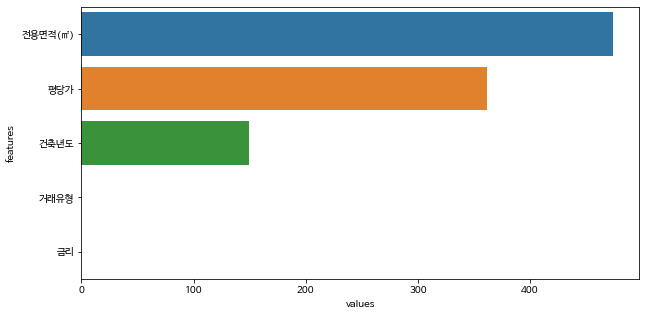

In [32]:
LGBM.feature_importances_
feature_imp = pd.DataFrame({'features': X_train.columns, 'values': LGBM.feature_importances_})
plt.figure(figsize=(10, 5))
sns.barplot(x='values', y='features',
            data=feature_imp.sort_values(by='values', ascending=False).head(10))
plt.show()

In [84]:
#@title RMSE 평가
def rmse_error(y, y_pred):
  rmse = mean_squared_error(y, y_pred, squared = False)
  return rmse

print(rmse_error(LGBM.predict(X_train),y_train))
print(rmse_error(LGBM.predict(X_test),y_test))

2636.8469330141975
2967.633309176917


In [55]:
y_test

날짜
2023-02-07    25500
2023-02-23    16000
2023-02-23    23000
2023-02-11    29000
2023-02-18    59500
              ...  
2023-02-16    23000
2023-02-21    23000
2023-02-02    20800
2023-02-02    40000
2023-02-16    49000
Name: 거래금액(만원), Length: 32005, dtype: int64

In [50]:
y_pred

array([25155.63927512, 16457.47947698, 23329.84603107, ...,
       21220.71275132, 40251.91486638, 49366.02915026])

In [83]:
# 모델 평가 및 예측
y_pred = LGBM.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

# # z-점수 계산
# X_mean = X.mean(axis=0)
# X_std = X.std(axis=0)
# X_z = (X - X_mean) / X_std
# print(X_z)

MSE: 8806847.46


In [89]:
# 새로운 데이터에 대한 예측
new_data = pd.DataFrame({
    '전용면적(㎡)': [84.930],
    '건축년도': [2005.0],
    '거래유형': [0],
    '평당가': [971.388202],
    '금리': [3.75]
})
predicted_price = LGBM.predict(new_data)  # 새로운 데이터에 대한 예측
print("Predicted price: %.2f" % predicted_price)  # 예측된 아파트 실거래가 출력


Predicted price: 25155.64


In [92]:
# test 데이터에 대한 예측
new_data = pd.DataFrame({
    '전용면적(㎡)': [164.0098	],
    '건축년도': [2009.0	],
    '거래유형': [0],
    '평당가': [1197.184558],
    '금리': [3.5]
}) ## 59500, -> 58962.26
predicted_price = LGBM.predict(new_data)  # 새로운 데이터에 대한 예측
print("Predicted price: %.2f" % predicted_price)  # 예측된 아파트 실거래가 출력

Predicted price: 58962.26


In [93]:
X_train

,전용면적(㎡),건축년도,거래유형,평당가,금리
날짜,,,,,
2023-01-04,84.930,1997.0,0,971.388202,3.25
2023-01-05,84.990,2005.0,0,1157.077303,3.25
2023-01-25,84.990,2005.0,0,1106.600777,3.50
2023-01-04,59.860,2002.0,1,1102.572670,3.25
2023-01-11,59.840,2002.0,0,1378.676471,3.25
...,...,...,...,...,...
2023-01-10,84.809,2019.0,0,1284.061833,3.25
2023-01-10,84.809,2019.0,0,1284.061833,3.25
2023-01-08,84.960,2019.0,0,1495.409605,3.25


In [94]:
y_train

날짜
2023-01-04    25000
2023-01-05    29800
2023-01-25    28500
2023-01-04    20000
2023-01-11    25000
              ...  
2023-01-10    33000
2023-01-10    33000
2023-01-08    38500
2023-01-16    37000
2023-01-28    40800
Name: 거래금액(만원), Length: 19998, dtype: int64

In [97]:
# train 데이터에 대한 예측
new_data = pd.DataFrame({
    '전용면적(㎡)': [84.809],
    '건축년도': [2019.0	],
    '거래유형': [0],
    '평당가': [1284.061833],
    '금리': [3.25]
}) ## 33000, -> 32930.44
predicted_price = LGBM.predict(new_data)  # 새로운 데이터에 대한 예측
print("Predicted price: %.2f" % predicted_price)  # 예측된 아파트 실거래가 출력

Predicted price: 32930.44


In [90]:
y_test

날짜
2023-02-07    25500
2023-02-23    16000
2023-02-23    23000
2023-02-11    29000
2023-02-18    59500
              ...  
2023-02-16    23000
2023-02-21    23000
2023-02-02    20800
2023-02-02    40000
2023-02-16    49000
Name: 거래금액(만원), Length: 32005, dtype: int64

In [91]:
X_test

,전용면적(㎡),건축년도,거래유형,평당가,금리
날짜,,,,,
2023-02-07,84.9450,1997.0,0,990.641003,3.5
2023-02-23,84.9450,1997.0,1,621.578669,3.5
2023-02-23,84.9450,1997.0,1,893.519336,3.5
2023-02-11,84.9900,2005.0,0,1126.014825,3.5
2023-02-18,164.0098,2009.0,0,1197.184558,3.5
...,...,...,...,...,...
2023-02-16,84.9289,2007.0,0,893.688721,3.5
2023-02-21,84.9289,2007.0,0,893.688721,3.5
2023-02-02,84.6800,2002.0,0,810.581011,3.5


In [82]:
from sklearn.metrics import accuracy_score
yy = pd.DataFrame(y_test.values.reshape(1,-1))
yy
LGBM.score(yy, y_pred)

ValueError: ignored